# GraphSAGE with Neo4j

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/connector/neo4j/undirected-graphsage-on-cora-neo4j-example.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/connector/neo4j/undirected-graphsage-on-cora-neo4j-example.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This example shows the application of GraphSAGE on the Cora dataset stored in Neo4j.

Subgraphs are sampled directly from Neo4j, which eliminate the need to store the whole graph structure in NetworkX. In this demo, node features are cached in memory for faster access since the dataset is relatively small.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.connector.neo4j import Neo4JGraphSAGENodeGenerator, Neo4jStellarGraph
from stellargraph.layer import GraphSAGE

import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import time
%matplotlib inline

## Connect to Neo4j

It is assumed that the cora dataset has already been loaded into Neo4j. [This notebook](./load-cora-into-neo4j.ipynb) demonstrates how to load cora dataset into Neo4j.

In [4]:
import py2neo

default_host = os.environ.get("STELLARGRAPH_NEO4J_HOST")

# Create the Neo4j Graph database object; the arguments can be edited to specify location and authentication
neo4j_graphdb = py2neo.Graph(host=default_host, port=None, user=None, password=None)

## Create a Neo4jStellarGraph object

Using the py2neo graph instance, we can create a `Neo4jStellarGraph` object that will be useful for the rest of the stellargraph workflow.

For this demo, we introduce two additional details that help us execute the notebook faster:

* Our Cora dataset loaded into Neo4j has an index on the `ID` property of `paper` entities. By specifying the `node_label` parameter when constructing `Neo4jStellarGraph`, this lets downstream queries to use this index and therefore run much faster, since many of the queries will require matching nodes by their `ID`.
* We also cache the node features in memory. Since we know the graph is relatively small, we can safely cache the node features in memory for faster access. Note that this should be avoided for larger graphs.

In [5]:
neo4j_sg = Neo4jStellarGraph(neo4j_graphdb, node_label="paper")
neo4j_sg.cache_all_nodes_in_memory()

## Data labels

In [6]:
# read the node labels from a seperate file
# note this function also returns a StellarGraph
# which we won't be using for this demo - we only need Neo4jStellarGraph!
_, labels = sg.datasets.Cora().load()

In [7]:
# split the node labels into train/test

train_labels, test_labels = model_selection.train_test_split(
    labels, train_size=0.1, test_size=None, stratify=labels
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
test_targets = target_encoding.transform(test_labels)

## Creating the GraphSAGE model in Keras

To feed data from the graph to the Keras model we need a data generator that feeds data from the graph to the model. The generators are specialized to the model and the learning task so we choose the `Neo4JGraphSAGENodeGenerator` as we are predicting node attributes with a GraphSAGE model, sampling directly from Neo4j database.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [8]:
batch_size = 50
num_samples = [10, 5]
epochs = 20

A `Neo4JGraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras.

In [9]:
generator = Neo4JGraphSAGENodeGenerator(neo4j_sg, batch_size, num_samples)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [10]:
train_gen = generator.flow(train_labels.index, train_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [11]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

Now we create a model to predict the 7 categories using Keras softmax layers.

In [12]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [13]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [14]:
test_gen = generator.flow(test_labels.index, test_targets)

In [15]:
history = model.fit(
    train_gen, epochs=epochs, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
6/6 - 6s - loss: 1.8865 - acc: 0.2815 - val_loss: 1.7291 - val_acc: 0.3638
Epoch 2/20
6/6 - 5s - loss: 1.6469 - acc: 0.4593 - val_loss: 1.5698 - val_acc: 0.5168
Epoch 3/20
6/6 - 5s - loss: 1.4777 - acc: 0.6741 - val_loss: 1.4366 - val_acc: 0.6173
Epoch 4/20
6/6 - 5s - loss: 1.3509 - acc: 0.7852 - val_loss: 1.3205 - val_acc: 0.6829
Epoch 5/20
6/6 - 5s - loss: 1.2084 - acc: 0.8296 - val_loss: 1.2169 - val_acc: 0.7047
Epoch 6/20
6/6 - 5s - loss: 1.0767 - acc: 0.8593 - val_loss: 1.1366 - val_acc: 0.7424
Epoch 7/20
6/6 - 6s - loss: 0.9664 - acc: 0.9074 - val_loss: 1.0686 - val_acc: 0.7670
Epoch 8/20
6/6 - 6s - loss: 0.8950 - acc: 0.9407 - val_loss: 0.9965 - val_acc: 0.7769
Epoch 9/20
6/6 - 6s - loss: 0.8022 - acc: 0.9519 - val_loss: 0.9425 - val_acc: 0.7974
Epoch 10/20
6/6 - 5s - loss: 0.7026 - acc: 0.9667 - val_loss: 0.9014 - val_acc: 0.7978
Epoch 11/20
6/6 - 5s - loss: 0.6610 - acc: 0.9593 - val_loss: 0.8637 - val_acc: 0.7966
Epoch 12/20
6/6 - 5s - loss: 0.6068 - acc: 0.9593 - 

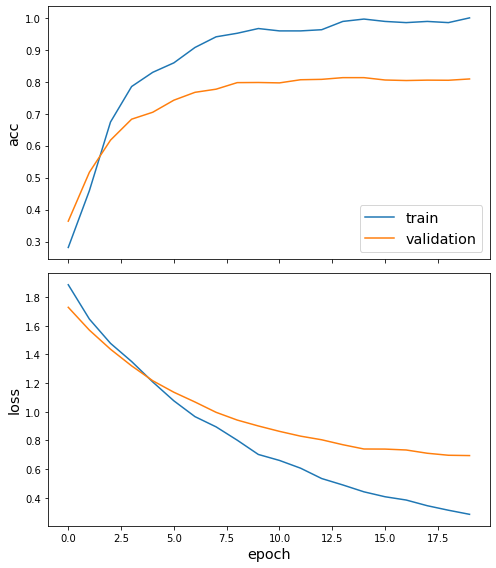

In [16]:
sg.utils.plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [17]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

49/49 [==============================] - 5s 106ms/step - loss: 0.6984 - acc: 0.8023

Test Set Metrics:
	loss: 0.6984
	acc: 0.8023


### Making predictions with the model

Now let's get the predictions themselves for all nodes using another node iterator:

In [18]:
all_nodes = labels.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [19]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [20]:
node_predictions

array(['Neural_Networks', 'Rule_Learning', 'Reinforcement_Learning', ...,
       'Genetic_Algorithms', 'Case_Based', 'Neural_Networks'],
      dtype='<U22')

Let's have a look at a few:

In [21]:
df = pd.DataFrame({"Predicted": node_predictions, "True": labels})
df.head(10)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Probabilistic_Methods,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


Please refer to [graphsage-node-classification.ipynb](./../../node-classification/graphsage-node-classification.ipynb) for **node embedding visualization**.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/connector/neo4j/undirected-graphsage-on-cora-neo4j-example.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/connector/neo4j/undirected-graphsage-on-cora-neo4j-example.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>